## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import nltk

In [2]:
quora_questions = pd.read_csv("/Users/brittanyharding/LHL-Projects/mini-project-V/train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [3]:
# Display the first few rows of the dataset
quora_questions.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
#Check Shape
quora_questions.shape

(404290, 6)

In [5]:
quora_questions.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

Total number of unique questions: 537933
Number of questions that appear multiple times: 111780


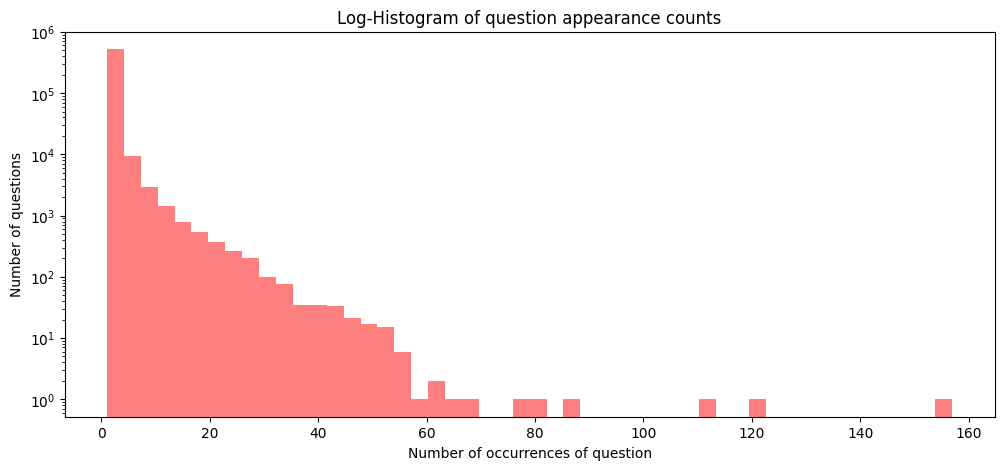

In [6]:
# Number of unique questions
unique_questions = pd.Series(quora_questions['qid1'].tolist() + quora_questions['qid2'].tolist())
print('Total number of unique questions:', len(np.unique(unique_questions)))

# Number of repeated questions
print('Number of questions that appear multiple times:', np.sum(unique_questions.value_counts() > 1))

# Histogram of question appearance counts
plt.figure(figsize=(12, 5))
plt.hist(unique_questions.value_counts(), bins=50, alpha=0.5, color= 'r', label='word in questions')
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')
plt.show()

In [7]:
# Check for any null values
print("Number of null in question1: ", quora_questions['question1'].isnull().sum())
print("Number of null in question2: ", quora_questions['question2'].isnull().sum())

Number of null in question1:  1
Number of null in question2:  2


In [8]:
# quora_questions = quora_questions.dropna(subset=['question1', 'question2'])

Class 0: 255027
Class 1: 149263
Proportion: 1.71 : 1


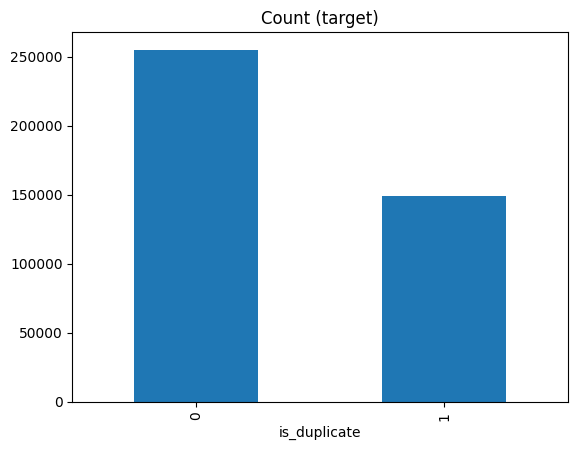

In [9]:
target_count = quora_questions['is_duplicate'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')
plt.show()

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [10]:
tqdm.pandas()

def preprocess_all(quora_questions, column):
    # Create new column names for the preprocessed text
    new_column = 'preprocessed_' + column
    
    # Fill null values with empty strings
    quora_questions[column].fillna('', inplace=True)
    
    # Remove punctuation
    quora_questions[new_column] = quora_questions[column].progress_apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)) if isinstance(x, str) else x)
    
    # Convert to lowercase
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: x.lower() if isinstance(x, str) else x)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: [word for word in x if word not in stop_words] if isinstance(x, list) else x)
    
    # Stem the tokens
    stemmer = PorterStemmer()
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: [stemmer.stem(word) for word in x] if isinstance(x, list) else x)
    
    # Join the tokens back into a single string
    quora_questions[new_column] = quora_questions[new_column].progress_apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    
    
    return quora_questions

In [11]:
preprocess_all(quora_questions, 'question1')
preprocess_all(quora_questions, 'question2')

100%|██████████| 404290/404290 [00:00<00:00, 811411.80it/s]


,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_question1,preprocessed_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water
...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,do you believe there is life after death,is it true that there is life after death
404287,404287,537928,537929,What is one coin?,What's this coin?,0,what is one coin,whats this coin
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,what is the approx annual cost of living while...,i am having little hairfall problem but i want...


In [12]:
import nltk

# Tokenization
quora_questions['tokenized_question1'] = quora_questions['preprocessed_question1'].apply(nltk.word_tokenize)
quora_questions['tokenized_question2'] = quora_questions['preprocessed_question2'].apply(nltk.word_tokenize)

In [23]:
# Check for any null values
print("Number of null: ", quora_questions.isnull().sum())

Number of null:  id                        0
qid1                      0
qid2                      0
question1                 0
question2                 0
is_duplicate              0
preprocessed_question1    0
preprocessed_question2    0
tokenized_question1       0
tokenized_question2       0
dtype: int64


In [20]:
# Drop rows where nulls appear in any column
quora_questions.dropna(inplace=True)

### Kernal keeps crashing due to memory limitations, updated CSV file to avoid need to repeat steps

In [33]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_preprocessed.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_preprocessed.csv')


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [39]:
quora_questions.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_question1,preprocessed_question2,tokenized_question1,tokenized_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,"['what', 'is', 'the', 'step', 'by', 'step', 'g...","['what', 'is', 'the', 'step', 'by', 'step', 'g..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,"['what', 'is', 'the', 'story', 'of', 'kohinoor...","['what', 'would', 'happen', 'if', 'the', 'indi..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,"['how', 'can', 'i', 'increase', 'the', 'speed'...","['how', 'can', 'internet', 'speed', 'be', 'inc..."


### Create a new column cosine similarity and calculate the similarity for each question pair

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract tokenized question data
tokenized_question1 = quora_questions['tokenized_question1']
tokenized_question2 = quora_questions['tokenized_question2']

# Combine tokenized questions into a list
all_tokenized_questions = tokenized_question1 + tokenized_question2

# Create the TF-IDF vectorizer
TfidfVec = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on the corpus
TfidfVec.fit(all_tokenized_questions)

def cos_similarity(text1, text2):
    tfidf = TfidfVec.transform([text1, text2])
    return (tfidf * tfidf.T).toarray()[0, 1]  # Return the cosine similarity between text1 and text2


In [45]:
# Create a new column 'cosine_similarity' and calculate the similarity for each pair
quora_questions['cosine_similarity'] = quora_questions.progress_apply(
    lambda row: cos_similarity(row['tokenized_question1'], row['tokenized_question2']), axis=1)

### Kernal keeps crashing due to memory limitations, updated CSV file to avoid need to repeat steps

In [2]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_cosine_similarity.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_cosine_similarity.csv')


### Create columns with Word2Vec and Common Words to Measure Semantic Similarity

In [3]:
# Calculate Word2Vec
word2vec_model = Word2Vec(pd.concat([quora_questions['tokenized_question1'], quora_questions['tokenized_question2']]), vector_size=100, window=5, min_count=1, workers=4)

# Calculate average Word2Vec for each question
quora_questions['word2vec_question1'] = quora_questions['tokenized_question1'].apply(lambda x: np.mean([word2vec_model.wv[word] for word in x], axis=0))
quora_questions['word2vec_question2'] = quora_questions['tokenized_question2'].apply(lambda x: np.mean([word2vec_model.wv[word] for word in x], axis=0))

# Calculate Common Words
quora_questions['common_words'] = quora_questions.apply(lambda row: len(set(row['tokenized_question1']).intersection(set(row['tokenized_question2']))), axis=1)

### Create columns for Length and Word Count Analysis:

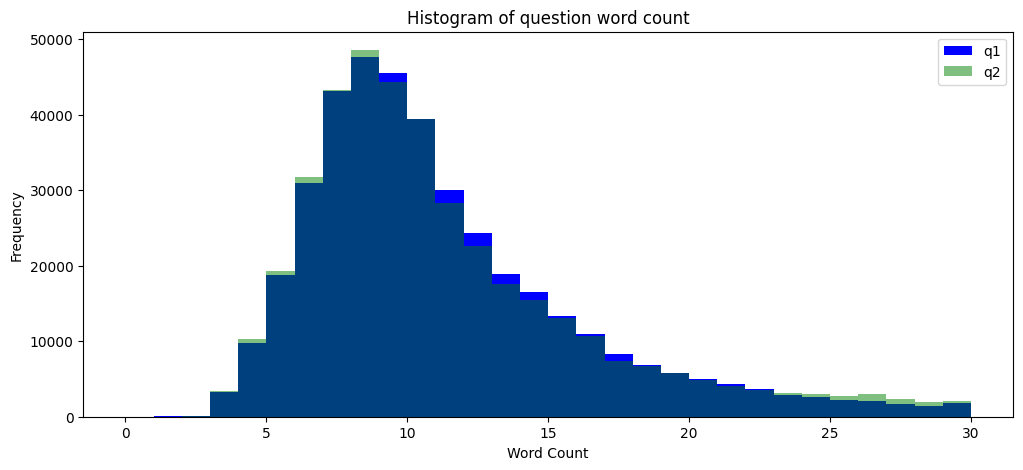

In [4]:
quora_questions['q1_len'] = quora_questions['question1'].str.len()
quora_questions['q2_len'] = quora_questions['question2'].str.len()

quora_questions['q1_word_count'] = quora_questions['question1'].apply(lambda x: len(str(x).split()))
quora_questions['q2_word_count'] = quora_questions['question2'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.hist(quora_questions['q1_word_count'], bins=30, range=[0, 30], color='blue', label='q1')
plt.hist(quora_questions['q2_word_count'], bins=30, range=[0, 30], color='green', alpha=0.5, label='q2')
plt.title('Histogram of question word count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Create column with Length Difference to measure the absolute difference in the lengths of preprocessed_question1 and preprocessed_question2:

In [5]:
quora_questions['length_difference'] = abs(quora_questions['preprocessed_question1'].str.len() - quora_questions['preprocessed_question2'].str.len())

### Create column with Jaccard Similarity to measure the overlap or similarity between two sets by calculating the size of the intersection divided by the size of the union of elements in the sets:

In [6]:
def jaccard_similarity(row):
    words_question1 = set(row['preprocessed_question1'].split())
    words_question2 = set(row['preprocessed_question2'].split())
    intersection = words_question1.intersection(words_question2)
    union = words_question1.union(words_question2)
    return len(intersection) / len(union)

quora_questions['jaccard_similarity'] = quora_questions.apply(jaccard_similarity, axis=1)

### Kernal keeps crashing due to memory limitations, updated CSV file to avoid need to repeat steps

In [7]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_jaccard.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_jaccard.csv')


### Create column with Levenshtein Distance as a measure of dissimilarity calculating the minimum number of single-character edits (insertions, deletions, or substitutions) required to transform one string into another:

In [8]:
from Levenshtein import distance as levenshtein_distance

quora_questions['levenshtein_distance'] = quora_questions.apply(
    lambda x: levenshtein_distance(x['preprocessed_question1'], x['preprocessed_question2']), axis=1
)


### Create Column with shared_bigrams and shared_trigrams to obtain a measure of similarity based on the overlapping sequences of words:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def shared_ngrams(q1, q2, n):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    if q1 == "NA" or q2 == "NA":
        return 0
    try:
        counts = vectorizer.fit_transform([q1, q2])
        return np.sum(np.minimum(counts.toarray()[0], counts.toarray()[1]))
    except ValueError:
        return 0

quora_questions['preprocessed_question1'] = quora_questions['preprocessed_question1'].apply(lambda x: x if isinstance(x, str) else "NA")
quora_questions['preprocessed_question2'] = quora_questions['preprocessed_question2'].apply(lambda x: x if isinstance(x, str) else "NA")

quora_questions['shared_bigrams'] = quora_questions.apply(lambda row: shared_ngrams(row['preprocessed_question1'], row['preprocessed_question2'], 2), axis=1)
quora_questions['shared_trigrams'] = quora_questions.apply(lambda row: shared_ngrams(row['preprocessed_question1'], row['preprocessed_question2'], 3), axis=1)

### Kernal keeps crashing due to memory limitations, updated CSV file to avoid need to repeat steps

In [10]:
# Export the DataFrame to a CSV file
quora_questions.to_csv('quora_questions_fe_complete.csv', index=False)

In [31]:
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import pandas as pd

tqdm.pandas()

nltk.download('vader_lexicon')

def get_sentiment(df, column, output_column):
    sia = SentimentIntensityAnalyzer()

    def get_score(text):
        sentiment = sia.polarity_scores(text)
        return sentiment['compound'] 

    df[output_column] = df[column].progress_apply(get_score)

    return df

# Apply sentiment analysis to 'question1' and 'question2'
quora_questions = get_sentiment(quora_questions, 'question1', 'sentiment1')
quora_questions = get_sentiment(quora_questions, 'question2', 'sentiment2')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brittanyharding/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 404273/404273 [01:23<00:00, 4844.27it/s]


In [34]:
# Create an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform question1 column
tfidf_question1 = tfidf_vectorizer.fit_transform(quora_questions['question1'])

# Transform question2 column
tfidf_question2 = tfidf_vectorizer.transform(quora_questions['question2'])

# Convert to sparse vectors
tfidf_question1 = tfidf_question1.toarray()
tfidf_question2 = tfidf_question2.toarray()

# Create new columns in the DataFrame with the TF-IDF vectors
quora_questions['tfidf_question1'] = list(tfidf_question1)
quora_questions['tfidf_question2'] = list(tfidf_question2)

In [40]:
import torch
from torchtext.vocab import GloVe
from tqdm import tqdm
import pandas as pd

# Load GloVe embeddings
embedding_glove = GloVe(name='6B', dim=100)

def compute_sentence_vector(sentence, embedding):
    words = sentence.split()
    vectors = [embedding[word] for word in words if word in embedding.stoi]
    
    if vectors:
        return torch.mean(torch.stack(vectors), dim=0)
    else:
        return torch.zeros(embedding.dim)

def cosine_similarity(vec1, vec2):
    dot_product = torch.dot(vec1, vec2)
    norm_vec1 = torch.norm(vec1)
    norm_vec2 = torch.norm(vec2)
    
    return dot_product / (norm_vec1 * norm_vec2)

# Assuming you have a pandas DataFrame named quora_questions with columns question1 and question2
similarities = []

for _, row in tqdm(quora_questions.iterrows(), total=quora_questions.shape[0]):
    vector1 = compute_sentence_vector(row['question1'], embedding_glove)
    vector2 = compute_sentence_vector(row['question2'], embedding_glove)
    similarity = cosine_similarity(vector1, vector2).item()
    similarities.append(similarity)

quora_questions['gloVe similarity'] = similarities


.vector_cache/glove.6B.zip: 862MB [02:44, 5.25MB/s]                               
100%|██████████| 404273/404273 [02:30<00:00, 2687.81it/s]


### Consider Running

In [ ]:
# Step 1: Retrieve word2vec vectors
word2vec_q1 = np.array(data['word2vec_question1'].tolist())
word2vec_q2 = np.array(data['word2vec_question2'].tolist())

# Step 2: Calculate average vector representation
avg_vector_q1 = np.mean(word2vec_q1, axis=1)
avg_vector_q2 = np.mean(word2vec_q2, axis=1)

# Step 3: Store average vector representations in a new column
quora_questions['avg_vector_q1'] = avg_vector_q1
quora_questions['avg_vector_q2'] = avg_vector_q2

In [ ]:
# Step 1: Retrieve the vectors you want to compare
vector1 = np.array(quora_questions['word2vec_question1'].tolist())
vector2 = np.array(quora_questions['word2vec_question2'].tolist())

# Step 2: Calculate the delta along each dimension
delta = vector2 - vector1

# Step 3: Add delta columns to the DataFrame
for i in range(delta.shape[1]):
    quora_questions[f'delta_dim_{i}'] = delta[:, i]

In [41]:
quora_questions.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_question1,preprocessed_question2,tokenized_question1,tokenized_question2,cosine_similarity,word2vec_question1,word2vec_question2,common_words,q1_len,q2_len,q1_word_count,q2_word_count,length_difference,jaccard_similarity,levenshtein_distance,shared_bigrams,shared_trigrams,sentiment,sentiment1,sentiment2,tfidf_question1,tfidf_question2,gloVe similarity
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,"['what', 'is', 'the', 'step', 'by', 'step', 'g...","['what', 'is', 'the', 'step', 'by', 'step', 'g...",0.982018,[ 0.00898745 0.18167198 0.6856871 0.638892...,[ 0.0219616 0.17617907 0.66709036 0.615194...,24,66,57,14,12,9,0.916667,9,11,10,0.0,0.2960,0.2960,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.993393
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,"['what', 'is', 'the', 'story', 'of', 'kohinoor...","['what', 'would', 'happen', 'if', 'the', 'indi...",0.833353,[-0.01708484 0.072957 0.73860765 0.673059...,[ 0.01563414 0.13440067 0.69234735 0.656880...,19,51,88,8,13,37,0.285714,42,2,1,0.0,0.3400,0.3400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.859209
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,"['how', 'can', 'i', 'increase', 'the', 'speed'...","['how', 'can', 'internet', 'speed', 'be', 'inc...",0.276467,[ 0.02145704 0.18500094 0.67908025 0.671455...,[ 0.0244764 0.12649077 0.6679733 0.668317...,21,73,59,14,10,14,0.200000,40,1,0,0.0,0.3182,0.2732,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.950457
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,"['why', 'am', 'i', 'mentally', 'very', 'lonely...","['find', 'the', 'remainder', 'when', 'math2324...",0.000000,[ 0.0148406 0.16174734 0.6620455 0.674011...,[-0.06324088 0.057978 0.45134827 0.609384...,17,50,65,11,9,7,0.000000,45,0,0,0.0,-0.3298,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.685542
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,"['which', 'one', 'dissolve', 'in', 'water', 'q...","['which', 'fish', 'would', 'survive', 'in', 's...",0.244119,[-0.00921589 0.1448649 0.6640431 0.652215...,[ 4.6148870e-04 1.8349576e-01 6.3167596e-01 ...,20,76,39,13,7,35,0.250000,51,0,0,0.0,0.0000,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.845631


In [2]:
# Export the DataFrame to a CSV file
# quora_questions.to_csv('quora_questions_fe_additions.csv', index=False)

# Load the CSV file into a DataFrame
quora_questions = pd.read_csv('quora_questions_fe_additions.csv')

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training set (90%) and testing set (10%)
quora_questions_train, quora_questions_test = train_test_split(quora_questions, test_size=0.1, random_state=42)

# Export the separated dataframes to .csv files
quora_questions_train.to_csv('quora_questions_train.csv', index=False)
quora_questions_test.to_csv('quora_questions_test.csv', index=False)


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [13]:
# Load the CSV file into a DataFrame
quora_questions_train = pd.read_csv('quora_questions_train.csv')

In [26]:
# Set the display options to show all columns
pd.set_option('display.max_columns', None)
quora_questions_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_question1,preprocessed_question2,tokenized_question1,tokenized_question2,cosine_similarity,word2vec_question1,word2vec_question2,common_words,q1_len,q2_len,q1_word_count,q2_word_count,length_difference,jaccard_similarity,levenshtein_distance,shared_bigrams,shared_trigrams
0,145787,24396,7296,What is a meaning of life?,What do you think is the ultimate meaning of l...,1,what is a meaning of life,what do you think is the ultimate meaning of life,"['what', 'is', 'a', 'meaning', 'of', 'life']","['what', 'do', 'you', 'think', 'is', 'the', 'u...",0.617332,[ 3.4653060e-03 2.0671563e-01 7.4044210e-01 ...,[ 0.00187344 0.16181543 0.72048426 0.656122...,18,26,50,6,10,24,0.454545,24,2,1
1,87944,64428,13778,What do you think about the idea of Narendra M...,What do you think will be the effect of Modi G...,1,what do you think about the idea of narendra m...,what do you think will be the effect of modi g...,"['what', 'do', 'you', 'think', 'about', 'the',...","['what', 'do', 'you', 'think', 'will', 'be', '...",0.250953,[-0.06716714 0.0703325 0.73442656 0.596455...,[-0.01347895 0.09746735 0.6874844 0.612820...,25,71,112,13,21,41,0.363636,60,3,2
2,117079,36776,12062,What is the best way to start learning C langu...,How do I start learning c language?,1,what is the best way to start learning c langu...,how do i start learning c language,"['what', 'is', 'the', 'best', 'way', 'to', 'st...","['how', 'do', 'i', 'start', 'learning', 'c', '...",0.757065,[ 0.03475159 0.14811525 0.63200307 0.629359...,[-0.03331681 0.14113799 0.67924976 0.730689...,19,65,35,13,7,30,0.250000,35,2,1
3,236867,199808,131262,What's the best way to learn any language?,How do I learn another spoken language?,0,whats the best way to learn any language,how do i learn another spoken language,"['whats', 'the', 'best', 'way', 'to', 'learn',...","['how', 'do', 'i', 'learn', 'another', 'spoken...",0.499921,[ 0.02591084 0.14075154 0.6606632 0.647621...,[-0.0428362 0.1263496 0.71104074 0.727097...,17,42,39,8,7,2,0.153846,25,0,0
4,26010,48454,48455,What is money for?,What is money?,0,what is money for,what is money,"['what', 'is', 'money', 'for']","['what', 'is', 'money']",1.000000,[ 1.26985330e-02 1.68828383e-01 7.34460533e-...,[ 0.01542537 0.16192687 0.72788876 0.687254...,16,18,14,4,3,4,0.750000,4,2,1


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [23]:
# Selecting columns to use as features in the model
features = quora_questions_train[['cosine_similarity', 'common_words', 'q1_len',
       'sentiment1',	'sentiment2',	'tfidf_question1',	'tfidf_question2',
       'q2_len', 'q1_word_count', 'q2_word_count', 'length_difference',
       'jaccard_similarity', 'levenshtein_distance', 'shared_bigrams',
       'shared_trigrams']]
target = quora_questions_train['is_duplicate']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Creating logistic regression model
log_reg = LogisticRegression(solver='liblinear')

# Training the model
log_reg.fit(X_train, y_train)

# Predicting the test set results
y_pred = log_reg.predict(X_test)

# Printing evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     45941
           1       0.60      0.51      0.55     26828

    accuracy                           0.70     72769
   macro avg       0.67      0.66      0.66     72769
weighted avg       0.69      0.70      0.69     72769

Confusion Matrix:
[[36820  9121]
 [13062 13766]]
Accuracy Score:
0.6951586527230001


In [25]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed
from tqdm import tqdm

# Define the hyperparameters
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))

# Define a function to train a model and compute its cross-validation score
def evaluate_model(params):
    model = LogisticRegression(**params)
    return cross_val_score(model, X_train, y_train, cv=5).mean()

# Evaluate all combinations of hyperparameters
cv_scores = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(params) for params in tqdm(all_params)
)

# Get the best parameters
best_params = all_params[np.argmax(cv_scores)]
print("Best Parameters: ", best_params)

# Train your model using the best parameters
log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train, y_train)

# Predicting the test set results
y_pred = log_reg.predict(X_test)

# Printing evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

100%|██████████| 40/40 [15:51<00:00, 23.78s/it]


Best Parameters:  {'C': 545.5594781168514, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     45941
           1       0.60      0.51      0.55     26828

    accuracy                           0.70     72769
   macro avg       0.67      0.66      0.66     72769
weighted avg       0.69      0.70      0.69     72769

Confusion Matrix:
[[36813  9128]
 [13064 13764]]
Accuracy Score:
0.6950349736838489


### Log Reg with Threshold

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Selecting columns to use as features in the model
features = quora_questions_train[['cosine_similarity', 'common_words', 'q1_len',
       'sentiment1', 'sentiment2', 'tfidf_question1', 'tfidf_question2',
       'q2_len', 'q1_word_count', 'q2_word_count', 'length_difference',
       'jaccard_similarity', 'levenshtein_distance', 'shared_bigrams',
       'shared_trigrams', 'sentiment1', 'sentiment2',
       'tfidf_question1', 'tfidf_question2', 'gloVe similarity']]
target = quora_questions_train['is_duplicate']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Creating logistic regression model
log_reg = LogisticRegression(solver='liblinear')

# Training the model
log_reg.fit(X_train, y_train)

# Set the threshold
threshold = 0.8

# Get the predicted probabilities for the positive class
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Apply the threshold to get the predicted labels based on the adjusted threshold
y_pred_threshold = (y_pred_proba > threshold).astype(int)

# Printing evaluation metrics with the adjusted threshold
print("Classification Report with Threshold:")
print(classification_report(y_test, y_pred_threshold))

print("Confusion Matrix with Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))

print("Accuracy Score with Threshold:")
print(accuracy_score(y_test, y_pred_threshold))

In [ ]:
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

# Define the hyperparameter search space
param_space = {
    'C': (0.001, 100.0, 'log-uniform'),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Create the BayesSearchCV object
opt = BayesSearchCV(
    LogisticRegression(),
    param_space,
    scoring='accuracy',
    n_iter=20,  # Number of iterations/evaluations
    cv=5,  # Number of cross-validation folds
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Perform the hyperparameter search with tqdm
with tqdm(total=opt.total_iterations) as pbar:
    opt.fit(X_train, y_train, callback=lambda x: pbar.update(1))

# Get the best parameters and score
best_params = opt.best_params_
best_score = opt.best_score_

# Train the model with the best parameters
log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train, y_train)

# Predicting the test set results
y_pred = log_reg.predict(X_test)

# Printing evaluation metrics
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

### Use Keras to Build NN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Concatenate
from keras.layers.embeddings import Embedding

# Selecting features to use in the model
features = quora_questions_train[['cosine_similarity', 'word2vec_question1_processed', 'word2vec_question2_processed', 
                                  'common_words', 'q1_len', 'q2_len', 'q1_word_count', 'q2_word_count', 
                                  'length_difference', 'jaccard_similarity', 'levenshtein_distance', 
                                  'shared_bigrams', 'shared_trigrams']]

target = quora_questions_train['is_duplicate']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define model
model = Sequential()

# Add an Embedding layer for word2vec_question1_processed
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())

# Add the first hidden layer
model.add(Dense(units=128, activation='relu'))

# Concatenate the additional features with the output of the first hidden layer
model.add(Concatenate())

# Add a second hidden layer
model.add(Dense(units=64, activation='relu'))

# Add output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))